In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

# The function used to generate data, the Runge function
def Runge_func(x):
    return 1.0/(1 + 25*x**2)

In [7]:
# Functions used

def polynomial_features(x, p, intercept=False):
    """
    Take an array of x values, and the desired polynomial degree p.
    Create a feature (design) matrix with first column x**1, second column with x**2, and so on. I.e. the i-th column containing x**(i+1).
    Intercept=True will turn the first column into ones, meaning the i-th column will contain the value x**(j).
    """
    n = len(x)
    x = x.ravel()
    if intercept  == True:
        X = np.zeros((int(n), int(p + 1)))
        for i in range(0, int(p+1)):
            X[:, i] = x**i  # Create first column with only ones (since x**0 = 1), the intercept column
    else:
        X = np.zeros((int(n), int(p)))
        for i in range(0, int(p)):
            X[:, i] = x**(i+1)
    return X

def OLS_parameters(X, y):
    """
    The closed form solution of least square optimization.
    Take a feature matrix X, and a column vector y.
    Return the parameters of OLS fit.
    """
    # The inverse of matrix X, using .pinv in case X is not square
    # The beta vector in: X @ beta = y, solved for beta
    beta = np.linalg.pinv(X.T @ X) @ X.T @ y   
    return beta

def Ridge_parameters(X, y, ridge_lambda):
    """
    The closed form solution of Ridge optimization.
    Take a feature matrix X, and a column vector y, and the Ridge lambda parameter.
    Return the beata parameters of the Ridge fit.
    """
    # Assumes X is scaled and has no intercept column
    I = np.identity(np.shape(X)[1])    # Create identity matrix same shape as X.T @ X, columns of X decide the shape, (nxm)(mxn)=(nxn)
    # Element-wise multiplication with *
    beta = np.linalg.pinv(X.T @ X + ridge_lambda*I) @ X.T @ y
    return beta

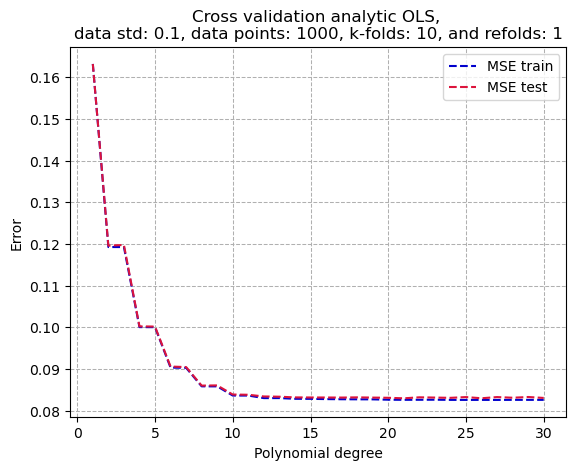

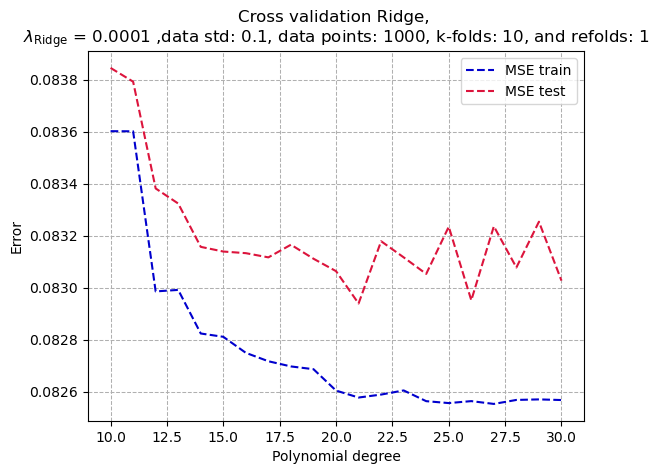

In [ ]:
# Cross-validation OLS analytic
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


# The function used to generate data, the Runge function
def Runge_func(x):
    return 1.0/(1 + 25*x**2)

np.random.seed(2025)

# Setting up data
n = 1000
std = 0.1
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, std, size=n)

max_poly_degree = 30
poly_degrees = np.arange(1, max_poly_degree + 1, 1) 

## Cross-validation on Ridge regression using repeated KFold
# Initialize a rKFold instance
k = 10
k_n = 1
rkfold = RepeatedKFold(n_splits=k, n_repeats=k_n)

# Perform the cross-validation to estimate MSE
#scores_KFold = np.zeros((nlambdas, k))
n_rkfolds = rkfold.get_n_splits()

scores_rKFold_train = np.zeros((len(poly_degrees), n_rkfolds))
scores_rKfold_test = np.zeros((len(poly_degrees), n_rkfolds))

beta_models = np.empty([len(poly_degrees), n_rkfolds], dtype=object)

for degree in range(len(poly_degrees)):

    j = 0
    for train_inds, test_inds in rkfold.split(x):
        x_train = x[train_inds]
        y_train = y[train_inds]
        x_test = x[test_inds]
        y_test = y[test_inds]

        X_train = polynomial_features(x_train, poly_degrees[degree], intercept=True)
        X_test = polynomial_features(x_test, poly_degrees[degree], intercept=True)

        # Scaling of the data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        beta = OLS_parameters(X_train_s, y_train)
        predictions_train = X_train_s @ beta
        predictions_test = X_test_s @ beta

        beta_models[degree,j] = beta.ravel()

        scores_rKFold_train[degree,j] = np.sum((predictions_train - y_train)**2)/len(predictions_train)
        scores_rKfold_test[degree,j] = np.sum((predictions_test - y_test)**2)/len(predictions_test)
        j += 1

mean_beta_model = np.mean(beta_models, axis=1)
estimated_mse_rKFold_train = np.mean(scores_rKFold_train, axis=1)
estimated_mse_rKFold_test = np.mean(scores_rKfold_test, axis=1)

plt.plot(poly_degrees, estimated_mse_rKFold_train, '--', color="mediumblue", label="MSE train")
plt.plot(poly_degrees, estimated_mse_rKFold_test, '--', color="crimson", label="MSE test")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Cross validation analytic OLS, \n"
          f"data std: {std}, data points: {n}, k-folds: {k}, and refolds: {k_n}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
#plt.savefig("bias_var_tradeoff.pdf", bbox_inches="tight")
plt.show()
plt.close()

plt.plot(poly_degrees[9:], estimated_mse_rKFold_train[9:], '--', color="mediumblue", label="MSE train")
plt.plot(poly_degrees[9:], estimated_mse_rKFold_test[9:], '--', color="crimson", label="MSE test")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Cross validation Ridge, \n"
          f"$\lambda_{{\\text{{Ridge}}}}$ = {ridge_lambda} ,data std: {std}, data points: {n}, k-folds: {k}, and refolds: {k_n}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
#plt.savefig("bias_var_tradeoff.pdf", bbox_inches="tight")
plt.show()
plt.close()

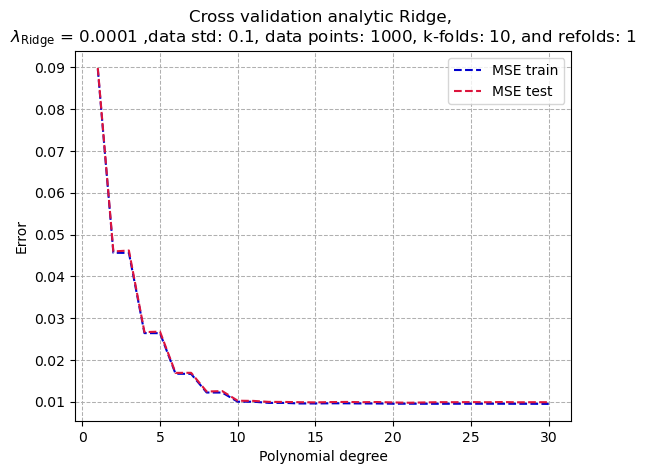

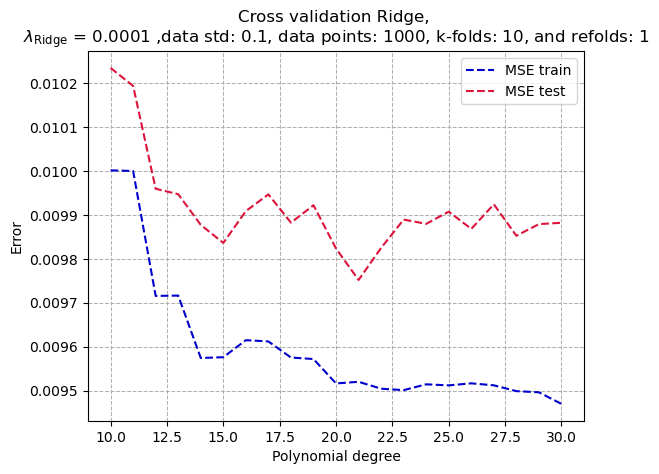

In [83]:
# Cross-validation Ridge
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures


# The function used to generate data, the Runge function
def Runge_func(x):
    return 1.0/(1 + 25*x**2)

np.random.seed(2025)

# Setting up data
n = 1000
std = 0.1
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, std, size=n)

max_poly_degree = 30
poly_degrees = np.arange(1, max_poly_degree + 1, 1)

ridge_lambda = 1e-4

## Cross-validation on Ridge regression using repeated KFold
# Initialize a rKFold instance
k = 10
k_n = 1
rkfold = RepeatedKFold(n_splits=k, n_repeats=k_n)

# Perform the cross-validation to estimate MSE
#scores_KFold = np.zeros((nlambdas, k))
n_rkfolds = rkfold.get_n_splits()

scores_rKFold_train = np.zeros((len(poly_degrees), n_rkfolds))
scores_rKfold_test = np.zeros((len(poly_degrees), n_rkfolds))

beta_models = np.empty([len(poly_degrees), n_rkfolds], dtype=object)

for degree in range(len(poly_degrees)):

    j = 0
    for train_inds, test_inds in rkfold.split(x):
        x_train = x[train_inds]
        y_train = y[train_inds]
        x_test = x[test_inds]
        y_test = y[test_inds]
        
        y_train_center = np.mean(y_train)

        X_train = polynomial_features(x_train, poly_degrees[degree], intercept=False)
        X_test = polynomial_features(x_test, poly_degrees[degree], intercept=False)

        # Scaling of the data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        beta = Ridge_parameters(X_train_s, y_train, ridge_lambda=ridge_lambda)
        predictions_train = X_train_s @ beta + y_train_center
        predictions_test = X_test_s @ beta + y_train_center

        beta_models[degree,j] = beta.ravel()

        scores_rKFold_train[degree,j] = np.sum((predictions_train - y_train)**2)/len(predictions_train)
        scores_rKfold_test[degree,j] = np.sum((predictions_test - y_test)**2)/len(predictions_test)
        j += 1

mean_beta_model = np.mean(beta_models, axis=1)
estimated_mse_rKFold_train = np.mean(scores_rKFold_train, axis=1)
estimated_mse_rKFold_test = np.mean(scores_rKfold_test, axis=1)
plt.plot(poly_degrees, estimated_mse_rKFold_train, '--', color="mediumblue", label="MSE train")
plt.plot(poly_degrees, estimated_mse_rKFold_test, '--', color="crimson", label="MSE test")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Cross validation analytic Ridge, \n"
          f"$\lambda_{{\\text{{Ridge}}}}$ = {ridge_lambda} ,data std: {std}, data points: {n}, k-folds: {k}, and refolds: {k_n}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
#plt.savefig("bias_var_tradeoff.pdf", bbox_inches="tight")
plt.show()
plt.close()

plt.plot(poly_degrees[9:], estimated_mse_rKFold_train[9:], '--', color="mediumblue", label="MSE train")
plt.plot(poly_degrees[9:], estimated_mse_rKFold_test[9:], '--', color="crimson", label="MSE test")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Cross validation Ridge, \n"
          f"$\lambda_{{\\text{{Ridge}}}}$ = {ridge_lambda} ,data std: {std}, data points: {n}, k-folds: {k}, and refolds: {k_n}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
#plt.savefig("bias_var_tradeoff.pdf", bbox_inches="tight")
plt.show()
plt.close()

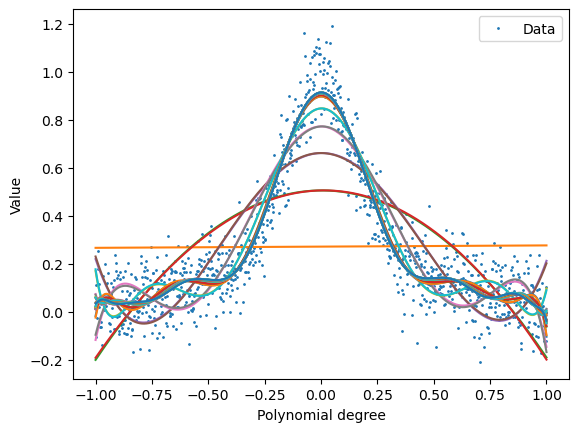

In [81]:
plt.plot(x, y, '.', markersize="2", label="Data")
plt.legend()
for i in range(len(poly_degrees)):
    X = polynomial_features(x, poly_degrees[i], intercept=False)
    scaler = StandardScaler()
    scaler.fit(X)
    X_s = scaler.transform(X)
    y_center = np.mean(y)
    plt.plot(x, X_s @ mean_beta_model[i] + y_center, label=f"P{poly_degrees[i]}")
plt.xlabel("Polynomial degree")
plt.ylabel("Value")
plt.show()
plt.close()

In [14]:
# Cross-validation Lasso
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold

def grad_C_Lasso(XTX, XTy, theta, n, lasso_lambda):
    """ 
    Calculate the gradient of the cost function C for Lasso. Original expression: (2.0/n)*(X.T @ X @ theta - X.T @ y) + 2*lasso_lambda*theta.
    Take the matrix multiplication involving features X.T@X, and X.T@y; target vector y; the parameter vector theta; n data point; and lasso_lambda. 
    Usually used in a grad decent/accent loop, therefore having X.T@X and X.T@y precalculated for speed improvement. 
    Return the calculated gradient. 
    """
    theta = theta.reshape(-1,1)
    XTy = XTy.reshape(-1, 1)
    return (2.0/n)*(XTX @ theta - XTy) + lasso_lambda*np.sign(theta)

def simple_gradient_decent_Lasso(X, y, theta, n, lasso_lambda=0.01, eta=0.01, precision=1e-8, num_iter=10000):
    """
    Find the theta that minimize the Lasso cost function iteratively. Run till precision requirement epsilon is met.
    Take feature matrix X, target vector y, parameter vector theta, n data points, lasso_lambda, learning rate eta, 
    precision of grad==0, and number of iterations num_iter.
    Return updated parameter vector theta, and number of iterations used i.
    """
    y = y.reshape(-1,1)
    theta = theta.reshape(-1,1)
    if np.shape(X)[0] != np.shape(y)[0]:
        raise ValueError("X and y is not of right shape")
    XTX = X.T @ X
    XTy = X.T @ y
    i = 0
    grad = grad_C_Lasso(XTX, XTy, theta, n, lasso_lambda)
    while np.linalg.norm(grad) > precision:
        theta -= eta*grad
        grad = grad_C_Lasso(XTX, XTy, theta, n, lasso_lambda)
        i += 1
        if i > num_iter:
            break
    return theta, i

np.random.seed(2025)

# Setting up data
n = 1000
std = 0.1
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, std, size=n)

max_poly_degree = 30
poly_degrees = np.arange(1, max_poly_degree + 1, 1)

lasso_lambda = 1e-4

## Cross-validation on Ridge regression using repeated KFold
# Initialize a rKFold instance
k = 10
k_n = 1
rkfold = RepeatedKFold(n_splits=k, n_repeats=k_n)

# Perform the cross-validation to estimate MSE
#scores_KFold = np.zeros((nlambdas, k))
n_rkfolds = rkfold.get_n_splits()

scores_rKFold_train = np.zeros((len(poly_degrees), n_rkfolds))
scores_rKfold_test = np.zeros((len(poly_degrees), n_rkfolds))

theta_models = np.empty([len(poly_degrees), n_rkfolds], dtype=object)

for degree in range(len(poly_degrees)):

    j = 0
    for train_inds, test_inds in rkfold.split(x):
        x_train = x[train_inds]
        y_train = y[train_inds]
        x_test = x[test_inds]
        y_test = y[test_inds]
        
        y_train_center = np.mean(y_train)

        X_train = polynomial_features(x_train, poly_degrees[degree], intercept=False)
        X_test = polynomial_features(x_test, poly_degrees[degree], intercept=False)

        # Scaling of the data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        # theta parameters from gradient decent method
        learning_rate = 0.001
        precision = 0.001
        num_iterations = 10000
        theta_start = np.ones([np.shape(X_train_s)[1]])

        theta_grad_decent, iterations = simple_gradient_decent_Lasso(X_train_s, y_train, theta_start, n, lasso_lambda=lasso_lambda, eta=learning_rate, precision=precision, num_iter=num_iterations)

        predictions_train = X_train_s @ theta_grad_decent + y_train_center
        predictions_test = X_test_s @ theta_grad_decent + y_train_center

        theta_models[degree,j] = theta_grad_decent.ravel()

        scores_rKFold_train[degree,j] = np.sum((predictions_train - y_train)**2)/len(predictions_train)
        scores_rKfold_test[degree,j] = np.sum((predictions_test - y_test)**2)/len(predictions_test)
        j += 1

mean_theta_model = np.mean(theta_models, axis=1)
estimated_mse_rKFold_train = np.mean(scores_rKFold_train, axis=1)
estimated_mse_rKFold_test = np.mean(scores_rKfold_test, axis=1)

In [15]:
iterations

10001

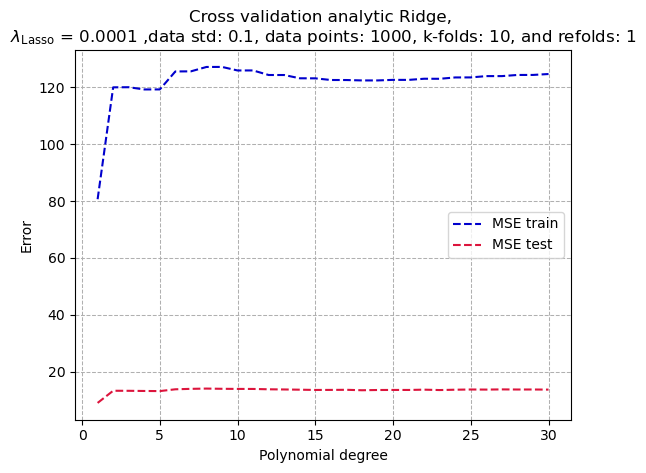

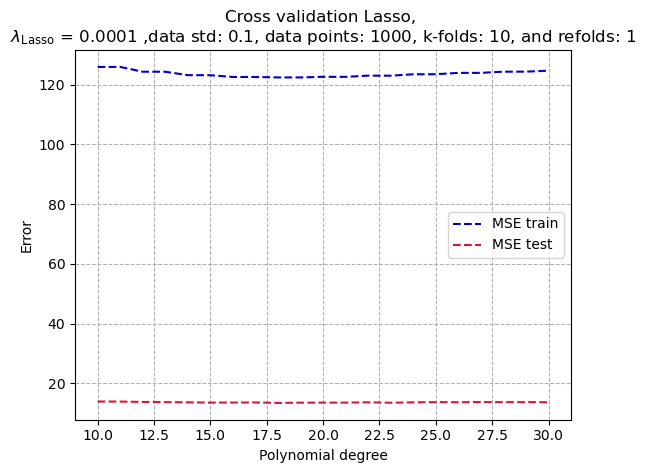

In [16]:
plt.plot(poly_degrees, estimated_mse_rKFold_train, '--', color="mediumblue", label="MSE train")
plt.plot(poly_degrees, estimated_mse_rKFold_test, '--', color="crimson", label="MSE test")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Cross validation analytic Ridge, \n"
          f"$\lambda_{{\\text{{Lasso}}}}$ = {lasso_lambda} ,data std: {std}, data points: {n}, k-folds: {k}, and refolds: {k_n}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
plt.show()
plt.close()

plt.plot(poly_degrees[9:], estimated_mse_rKFold_train[9:], '--', color="mediumblue", label="MSE train")
plt.plot(poly_degrees[9:], estimated_mse_rKFold_test[9:], '--', color="crimson", label="MSE test")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Cross validation Lasso, \n"
          f"$\lambda_{{\\text{{Lasso}}}}$ = {lasso_lambda} ,data std: {std}, data points: {n}, k-folds: {k}, and refolds: {k_n}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
plt.show()
plt.close()